In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time

# Import classifiers to test
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Import metrics to analyze results
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Import functions for cross validation and parameter optimization
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

/Users/chrisgiler_developer/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/chrisgiler_developer/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',
       'exercised_stock_options', 'bonus', 'restricted_stock',
       'shared_receipt_with_poi', 'restricted_stock_deferred',
       'total_stock_value', 'expenses', 'loan_advances', 'from_messages',
       'other', 'from_this_person_to_poi', 'director_fees',
       'deferred_income', 'long_term_incentive',
       'from_poi_to_this_person']

In [3]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
len(data_dict.keys())

146

In [5]:
for item in data_dict['METTS MARK'].keys():
    print item, data_dict['METTS MARK'][item]
print len(data_dict['METTS MARK'].keys())

salary 365788
to_messages 807
deferral_payments NaN
total_payments 1061827
exercised_stock_options NaN
bonus 600000
restricted_stock 585062
shared_receipt_with_poi 702
restricted_stock_deferred NaN
total_stock_value 585062
expenses 94299
loan_advances NaN
from_messages 29
other 1740
from_this_person_to_poi 1
poi False
director_fees NaN
deferred_income NaN
long_term_incentive NaN
email_address mark.metts@enron.com
from_poi_to_this_person 38
21


### Number of data points
Number of POI vs. Non-POI

In [6]:
print 'DATA POINTS'
print '==========='
print len(data_dict), 'total data points'
count_poi = 0
for person in data_dict:
    if data_dict[person]['poi'] == 1:
        count_poi += 1
        print person
print count_poi, 'POI;	', len(data_dict) - count_poi, 'non-POI'

DATA POINTS
146 total data points
HANNON KEVIN P
COLWELL WESLEY
RIEKER PAULA H
KOPPER MICHAEL J
SHELBY REX
DELAINEY DAVID W
LAY KENNETH L
BOWEN JR RAYMOND M
BELDEN TIMOTHY N
FASTOW ANDREW S
CALGER CHRISTOPHER F
RICE KENNETH D
SKILLING JEFFREY K
YEAGER F SCOTT
HIRKO JOSEPH
KOENIG MARK E
CAUSEY RICHARD A
GLISAN JR BEN F
18 POI;	128 non-POI


### Convert all 'str' and 'int' types to 'float' type

In [7]:
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN',np.nan)
df = df.drop('email_address', 1)

# Convert NaN to Median Value
df = df.apply(lambda x: x.fillna(x.median()), axis=0)

# Create new features
# Fraction from poi
df['fraction_from_poi'] = df['from_poi_to_this_person']/df['from_messages']
features_list.append('fraction_from_poi')
# Fraction to poi
df['fraction_to_poi'] = df['from_this_person_to_poi']/df['to_messages']
features_list.append('fraction_to_poi')

data_dict = df.T.to_dict()

### Number of Features
Split by type

In [8]:
print 'FEATURES'
print '========'
first_key = data_dict.keys()[0]
print len(data_dict[first_key].keys()), 'features total'
print
print 'Feature breakdown:'
data_types = defaultdict(list)
for key in data_dict[first_key].keys():
	data_type = type(data_dict[first_key][key])
	data_types[data_type].append(key)
print
print 'Data Types:'
for key in data_types:
	print key,':'
#	for item in data_types[key]:
#		print '   ', item
	print data_types[key]
	print '------------'

print np.isnan(data_dict['LOCKHART EUGENE E']['salary'])

FEATURES
22 features total

Feature breakdown:

Data Types:
<type 'float'> :
['to_messages', 'deferral_payments', 'expenses', 'long_term_incentive', 'from_poi_to_this_person', 'deferred_income', 'fraction_from_poi', 'restricted_stock_deferred', 'shared_receipt_with_poi', 'loan_advances', 'from_messages', 'other', 'director_fees', 'bonus', 'total_stock_value', 'from_this_person_to_poi', 'restricted_stock', 'salary', 'total_payments', 'fraction_to_poi', 'exercised_stock_options']
------------
<type 'bool'> :
['poi']
------------
False


### Number of NaN values

In [9]:
print 'MISSING DATA (NaN)'
print '=================='
print 'Count of NaN Values (for each feature) :'
print
# Initialize Counts:
count_nan = defaultdict(int)
for key in data_dict[first_key].keys():
	count_nan[key] = 0
# Increment Counter
for person in data_dict:
	for key in data_dict[person].keys():
		if np.isnan(data_dict[person][key]):
			count_nan[key] += 1
# Sort dictionary by value and print values
for key in sorted(count_nan, key=count_nan.get, reverse=True):
    print key, count_nan[key]

print 
print
print 'NaN by Data Point'
print '================='
count_nan_ind = defaultdict(int)
for person in data_dict:
	cnt = 0
	for key in data_dict[person].keys():
		if np.isnan(data_dict[person][key]):
			cnt += 1
	count_nan_ind[person] = cnt

for key in sorted(count_nan_ind, key = count_nan_ind.get, reverse=True)[0:14]:
	print key, count_nan_ind[key]

MISSING DATA (NaN)
Count of NaN Values (for each feature) :

to_messages 0
deferral_payments 0
expenses 0
poi 0
deferred_income 0
long_term_incentive 0
fraction_from_poi 0
restricted_stock_deferred 0
shared_receipt_with_poi 0
loan_advances 0
from_messages 0
other 0
director_fees 0
bonus 0
total_stock_value 0
from_poi_to_this_person 0
from_this_person_to_poi 0
restricted_stock 0
salary 0
total_payments 0
fraction_to_poi 0
exercised_stock_options 0


NaN by Data Point
METTS MARK 0
BAXTER JOHN C 0
ELLIOTT STEVEN 0
CORDES WILLIAM R 0
HANNON KEVIN P 0
MORDAUNT KRISTINA M 0
MEYER ROCKFORD G 0
MCMAHON JEFFREY 0
HAEDICKE MARK E 0
PIPER GREGORY F 0
HUMPHREY GENE E 0
NOLES JAMES L 0
BLACHMAN JEREMY M 0
SUNDE MARTIN 0


### Remove Outliers
'TOTAL'

'THE TRAVEL AGENCY IN THE PARK'

'LOCKHART EUGENE E'

In [10]:
outliers = ['TOTAL','THE TRAVEL AGENCY IN THE PARK','LOCKHART EUGENE E']
print 'Initial Length:', len(data_dict)
for name in outliers:
    data_dict.pop(name)
print 'Length after Outlier Removal:', len(data_dict)

Initial Length: 146
Length after Outlier Removal: 143


### Feature Selection
Use SelectKBest

In [11]:
data = featureFormat(data_dict, features_list, remove_NaN=False, sort_keys=True)
labels, features = targetFeatureSplit(data)

### Feature scaling
from sklearn import preprocessing
features = preprocessing.MinMaxScaler().fit_transform(features)

### SelectKBest
selection = SelectKBest(k = 'all')
selection.fit(features, labels)
scores = selection.scores_
score_pairs = zip(features_list[1:], scores)
score_pairs = sorted(score_pairs, key = lambda x: x[1])
score_pairs.reverse()

top_features = ['poi']
for name, val in score_pairs:
    if len(top_features) <= 8:
        top_features.append(name)

k_best_features = dict(score_pairs[0:7], )
k_best_features

{'bonus': 15.646310196119428,
 'deferred_income': 10.183117569139776,
 'exercised_stock_options': 27.19264248325241,
 'restricted_stock': 8.3604406191721594,
 'salary': 10.806071863124094,
 'total_payments': 8.3349911967777608,
 'total_stock_value': 23.428992663609957}

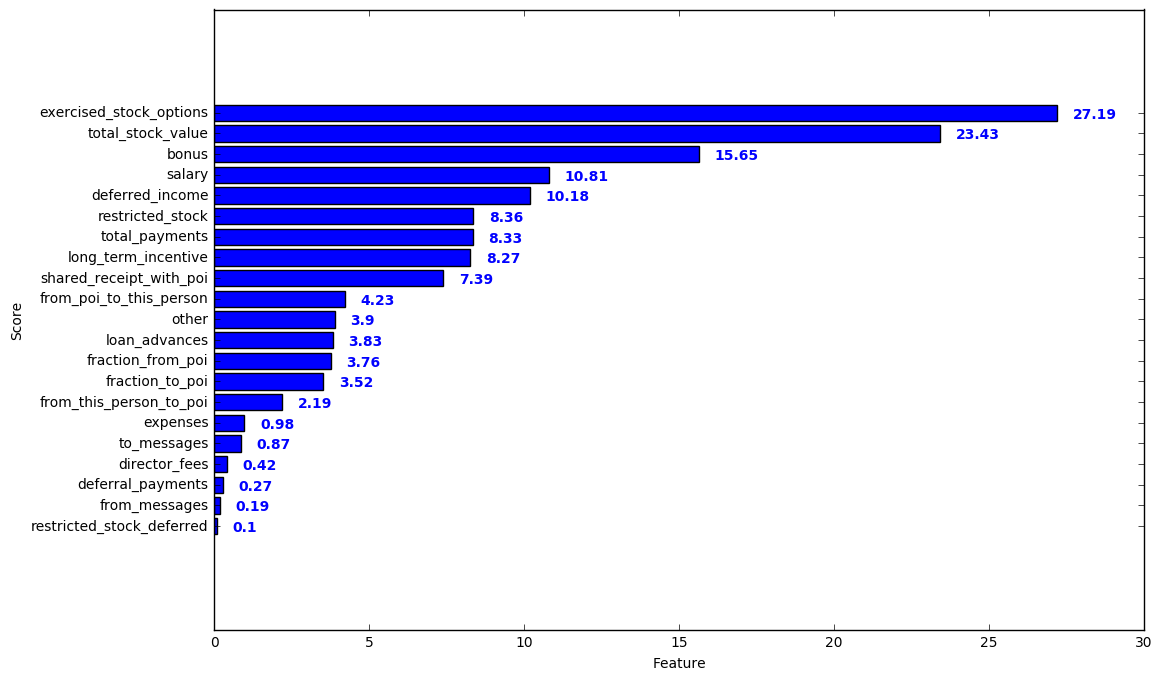

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  
features_names = zip(*score_pairs)[0]
score = zip(*score_pairs)[1]
x_pos = np.arange(len(features_names)) 
plt.figure(figsize=(12,8))
plt.barh(x_pos, score, align='center')
plt.yticks(x_pos, features_names) 
plt.ylabel('Score')
plt.xlabel('Feature')
plt.gca().invert_yaxis()
for i, v in enumerate(score):
    v = float("{0:.2f}".format(v))
    plt.text(v + .5, i+.25, str(v), color='blue', fontweight='bold')
plt.show()




Use SelectPercentile

In [13]:
'''
from sklearn.feature_selection import SelectPercentile
selector = SelectPercentile(percentile = 10)
selector.fit(features, labels)
perc_scores = selector.scores_

perc_dict = {}
for i in range(len(perc_scores)):
    perc_dict[features_list[i+1]] = perc_scores[i]

perc_dict

import operator
perc_dict = sorted(perc_dict.items(), key=operator.itemgetter(1))
perc_dict.reverse()
dict(perc_dict[0:7])
'''

'\nfrom sklearn.feature_selection import SelectPercentile\nselector = SelectPercentile(percentile = 10)\nselector.fit(features, labels)\nperc_scores = selector.scores_\n\nperc_dict = {}\nfor i in range(len(perc_scores)):\n    perc_dict[features_list[i+1]] = perc_scores[i]\n\nperc_dict\n\nimport operator\nperc_dict = sorted(perc_dict.items(), key=operator.itemgetter(1))\nperc_dict.reverse()\ndict(perc_dict[0:7])\n'

In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
import operator

# Reload data using only top 10 features found through K-Best Selection
data = featureFormat(data_dict, top_features, sort_keys=True)
labels, features = targetFeatureSplit(data)
### Feature scaling
from sklearn import preprocessing
features = preprocessing.MinMaxScaler().fit_transform(features)

# create a base classifier used to evaluate a subset of attributes
# model = LogisticRegression()
model = LogisticRegression()
model_fi = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(model, 1)
rfe = rfe.fit(features, labels)

# Use model_fi to find feature importance
model_fi.fit(features, labels)
feat_imp = model_fi.feature_importances_

# summarize the selection of the attributes
#print(rfe.support_)
#print(rfe.ranking_)

ranking_dict = {}
ranking = rfe.ranking_
for i in range(len(ranking)):
    ranking_dict[top_features[i+1]] = (feat_imp[i], ranking[i])
ranking_pairs = zip(top_features[1:], feat_imp, ranking)
ranking_pairs = sorted(ranking_pairs, key = lambda x: x[1])
ranking_pairs.reverse()

ranking_dict = sorted(ranking_dict.items(), key=operator.itemgetter(1))
ranking_dict.reverse()
ranking_pairs



[('exercised_stock_options', 0.20795814004577048, 1),
 ('salary', 0.14905112154355143, 6),
 ('total_stock_value', 0.1300182552791051, 3),
 ('deferred_income', 0.12703381561820251, 2),
 ('total_payments', 0.11427555674812111, 8),
 ('restricted_stock', 0.10848076107826676, 7),
 ('bonus', 0.08970034916388106, 4),
 ('long_term_incentive', 0.073482000523101568, 5)]

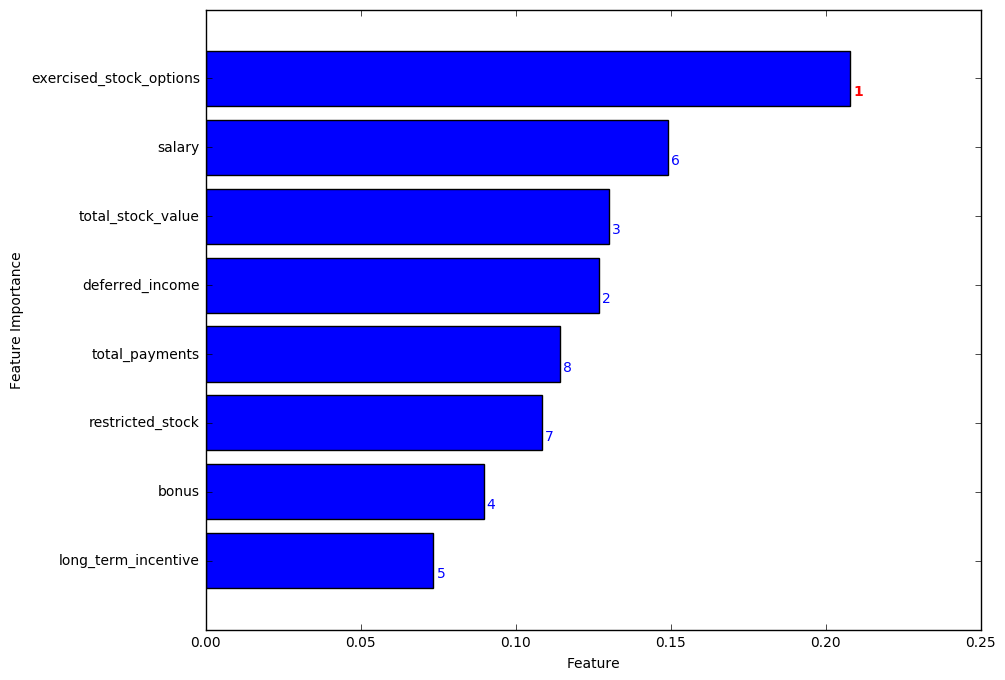

In [15]:
features_names = zip(*ranking_pairs)[0]
feature_importance = zip(*ranking_pairs)[1]
feature_ranking = zip(*ranking_pairs)[2]
x_pos = np.arange(len(features_names)) 

plt.figure(figsize=(10,8))
plt.barh(x_pos, feature_importance, align='center')
plt.yticks(x_pos, features_names) 
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.gca().invert_yaxis()
for i, v in enumerate(feature_importance):
    v = float("{0:.4f}".format(v))
    if feature_ranking[i] == 1:
        text_color = 'red'
        text_weight = 'bold'
    else:
        text_color = 'blue'
        text_weight = 'light'
    plt.text(v + .001, i+.25, str(feature_ranking[i]), color=text_color, fontweight=text_weight)
        
plt.show()

In [16]:
top_features = ['poi',
                'total_stock_value',
                'exercised_stock_options',
                'deferred_income',
                'bonus',
                'salary']

# Reload data using only top 10 features found through K-Best Selection
data = featureFormat(data_dict, top_features, sort_keys=True)
labels, features = targetFeatureSplit(data)

### Feature scaling
from sklearn import preprocessing
features = preprocessing.MinMaxScaler().fit_transform(features)

from sklearn.cross_validation import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(labels)

In [17]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC
clf = KNeighborsClassifier()
#X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=.3)
#clf.fit(X_train,y_train)
#y_pred = clf.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
print 'Accuracy:', np.mean(cross_val_score(clf, features, labels, scoring='accuracy', cv=cv))
print 'Recall:', np.mean(cross_val_score(clf, features, labels, scoring='recall', cv=cv))
print 'Precision:', np.mean(cross_val_score(clf, features, labels, scoring='precision', cv=cv))

#print 'Accuracy:', accuracy
#print 'Recall:', recall
#print 'Precision:', precision

Accuracy: 0.846666666667
Recall: 0.1
Precision: 0.2


/Users/chrisgiler_developer/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
def test_algorithm(clf, features, labels, score_str, cv):
    return np.mean(cross_val_score(clf,
                                   features,
                                   labels,
                                   scoring=score_str,
                                   cv=cv))

from sklearn.cross_validation import StratifiedShuffleSplit
import re

cv = StratifiedShuffleSplit(labels, n_iter = 100, test_size = 0.1, random_state = 10)
#print StratifiedShuffleSplit()

models = [GaussianNB(), LinearSVC(), LogisticRegression(), 
          DecisionTreeClassifier(), KNeighborsClassifier(), AdaBoostClassifier(),
          RandomForestClassifier()]

test_results = {}
for i in range(len(models)):
    clf = models[i]
    clf_str = re.split(r'\(', str(clf))[0]
    test_results[clf_str] = {}
    test_results[clf_str]['Accuracy'] = test_algorithm(clf,features,labels,'accuracy',cv)
    test_results[clf_str]['Precision'] = test_algorithm(clf,features,labels,'precision',cv)
    test_results[clf_str]['Recall'] = test_algorithm(clf,features,labels,'recall',cv)

df_results = pd.DataFrame.from_dict(test_results).T


In [19]:
df_results

,Accuracy,Precision,Recall
AdaBoostClassifier,0.824667,0.268333,0.240
DecisionTreeClassifier,0.765333,0.142333,0.200
GaussianNB,0.857333,0.413667,0.355
KNeighborsClassifier,0.859333,0.130000,0.070
LinearSVC,0.866000,0.236667,0.135
LogisticRegression,0.872000,0.145000,0.075
RandomForestClassifier,0.843333,0.220000,0.170


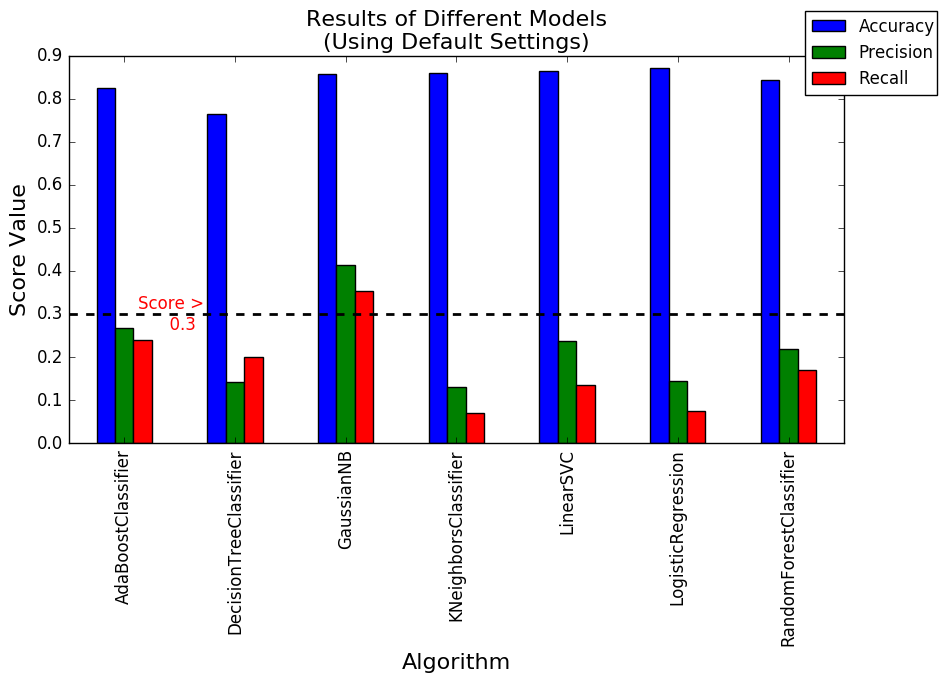

In [20]:
ax = df_results.plot(kind='bar',figsize=(10,5),fontsize=12)
ax.set_title('Results of Different Models\n(Using Default Settings)',fontsize=16)
ax.legend(bbox_to_anchor=(0.95, 0.9, .17, 0), loc=3, ncol=1, mode='expand', borderaxespad=0)
ax.text(.12,0.265,'Score > \n      0.3',fontsize=12,color='r')
ax.set_xlabel('Algorithm',fontsize=16)
ax.set_ylabel('Score Value',fontsize=16)
ax.plot([-.5, 6.5],[0.30, 0.30],'k--',linewidth=2)
plt.show()

In [92]:
test_classifier(RandomForestClassifier(),data_dict,top_features)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.84707	Precision: 0.34687	Recall: 0.16650	F1: 0.22500	F2: 0.18583
	Total predictions: 15000	True positives:  333	False positives:  627	False negatives: 1667	True negatives: 12373



In [28]:
from sklearn.grid_search import GridSearchCV

# Perform for RandomForestClassifier() and AdaBoostClassifier()
parameters_rfc = {'n_estimators':[1, 2, 5, 10, 20, 40, 100], 
                  'min_samples_split':[2, 3, 4, 5, 6, 7, 8], 
                  'min_samples_leaf':[1, 2, 3, 5, 10, 15]}
parameters_abc = {'n_estimators':[2, 5, 10, 15, 20, 30, 40, 50], 
                  'algorithm':('SAMME.R','SAMME'), 
                  'random_state':[10, 20, 30, 40, 50, 60]}
parameters_svr = {'loss':('squared_hinge', 'hinge'), 'C':[1, 10]}


rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
svr = LinearSVC()

clf = GridSearchCV(abc, parameters_abc)
clf.fit(features, labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [2, 5, 10, 15, 20, 30, 40, 50], 'random_state': [10, 20, 30, 40, 50, 60], 'algorithm': ('SAMME.R', 'SAMME')},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [29]:
clf.best_params_

{'algorithm': 'SAMME.R', 'n_estimators': 5, 'random_state': 10}

In [71]:
test_classifier(clf.best_estimator_,data_dict,top_features)
#test_classifier(AdaBoostClassifier(),data_dict,top_features)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
          n_estimators=5, random_state=10)
	Accuracy: 0.84740	Precision: 0.31012	Recall: 0.11800	F1: 0.17095	F2: 0.13469
	Total predictions: 15000	True positives:  236	False positives:  525	False negatives: 1764	True negatives: 12475



In [68]:
test_classifier(AdaBoostClassifier(),data_dict,top_features)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.81880	Precision: 0.25478	Recall: 0.18650	F1: 0.21536	F2: 0.19706
	Total predictions: 15000	True positives:  373	False positives: 1091	False negatives: 1627	True negatives: 11909



In [93]:
test_classifier(GaussianNB(), data_dict, top_features)

GaussianNB(priors=None)
	Accuracy: 0.86647	Precision: 0.49905	Recall: 0.39600	F1: 0.44159	F2: 0.41306
	Total predictions: 15000	True positives:  792	False positives:  795	False negatives: 1208	True negatives: 12205



In [ ]:
import matplotlib.pyplot as plt


100


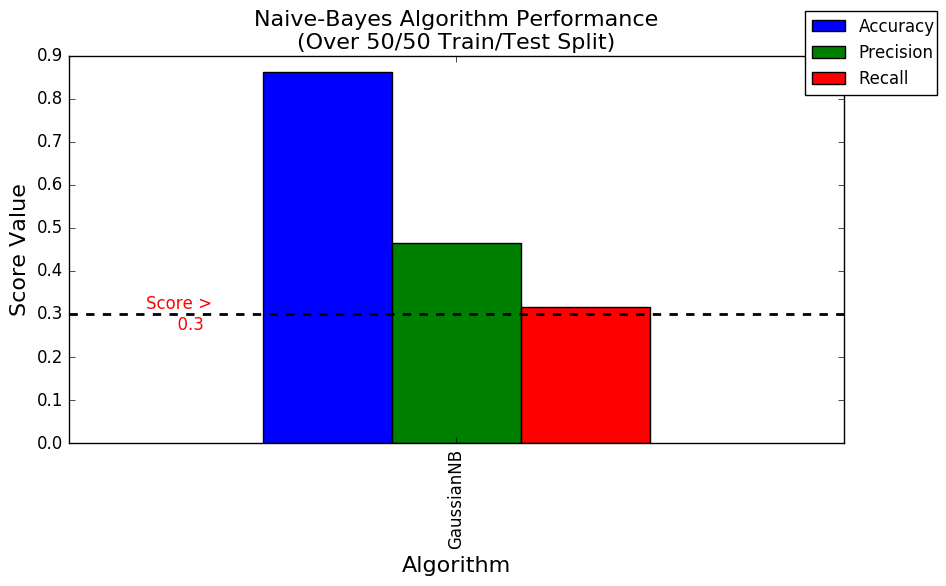

In [38]:
cv = StratifiedShuffleSplit(labels, n_iter = 100, test_size = 0.5, random_state = 10)
print cv.n_iter
#print StratifiedShuffleSplit()

#models = [GaussianNB(), AdaBoostClassifier(algorithm='SAMME.R',n_estimators=5,random_state=10),
#          RandomForestClassifier(n_estimators=2,min_samples_split=6,min_samples_leaf=1)]

models = [GaussianNB()]

test_results = {}
for i in range(len(models)):
    clf = models[i]
    clf_str = re.split(r'\(', str(clf))[0]
    test_results[clf_str] = {}
    test_results[clf_str]['Accuracy'] = test_algorithm(clf,features,labels,'accuracy',cv)
    test_results[clf_str]['Precision'] = test_algorithm(clf,features,labels,'precision',cv)
    test_results[clf_str]['Recall'] = test_algorithm(clf,features,labels,'recall',cv)

df_results = pd.DataFrame.from_dict(test_results).T

ax = df_results.plot(kind='bar',figsize=(10,5),fontsize=12)
#ax.set_title('Results of Different Models\n(Using Optimized Parameters)',fontsize=16)
ax.set_title('Naive-Bayes Algorithm Performance\n(Over 50/50 Train/Test Split)',fontsize=16)
ax.legend(bbox_to_anchor=(0.95, 0.9, .17, 0), loc=3, ncol=1, mode='expand', borderaxespad=0)
#ax.text(.12,0.265,'Score > \n      0.3',fontsize=12,color='r')
ax.text(-.4,0.265,'Score > \n      0.3',fontsize=12,color='r')
ax.set_xlabel('Algorithm',fontsize=16)
ax.set_ylabel('Score Value',fontsize=16)
ax.plot([-.5, 6.5],[0.30, 0.30],'k--',linewidth=2)
plt.show()